<a href="https://colab.research.google.com/github/DivyaNarayan0613/DivyaNarayan0613/blob/main/Complete_Code_Osteocarcinoma_on_real_medical_data_and_DNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/chandranvenkatesan/detecting-lung-cancer-vgg16-resnet-efficientnet

In [ ]:


import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

SEED = 15243
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 25
DATA_DIR = ('/content/drive/MyDrive/Prepared Data')
IMG_SIZE = 256
MAX_EPOCHS = 25
class_names = ["Non Tumor", "Non Viable Tumor", "Viable"]
class_details = ["No Cancer", "Can be effectively treated", "Living mass of cancerous cells"]


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="training",
    validation_split=0.2
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="validation",
    validation_split=0.2
)

Found 549 files belonging to 3 classes.
Using 440 files for training.
Found 549 files belonging to 3 classes.
Using 109 files for validation.


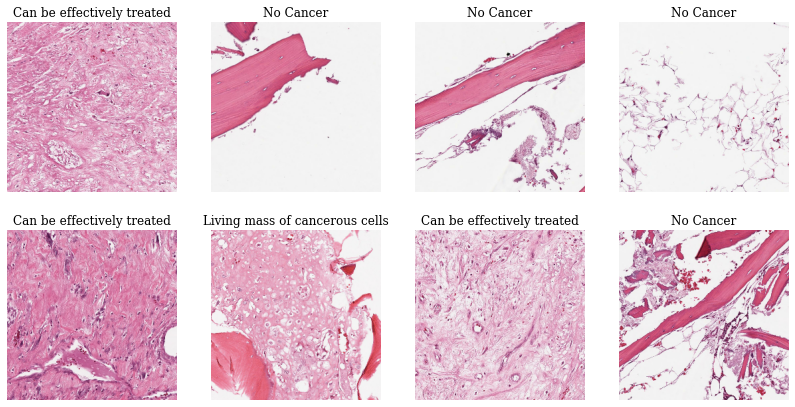

In [ ]:


plt.figure(figsize=(14, 7))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_details[labels[i]])
        plt.axis("off")



In [ ]:
# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache(".cached-data").prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


def compile_and_fit_model(model: tf.keras.Sequential) -> tf.keras.callbacks.History:
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=5,
        mode="auto",
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=MAX_EPOCHS,
        callbacks=[early_stopping, reduce_lr]
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history


def plot_predictions(model: tf.keras.Sequential) -> None:
    plt.figure(figsize=(14, 14))
    for images, labels in train_ds.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i, (actual, pred) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if actual == pred:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

In [ ]:
pretrained_vgg16_base = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_vgg16_base.trainable = False

vgg16_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
    pretrained_vgg16_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
vgg16_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 14,780,739
Trainable params: 66,051
Non-trainable params: 14,714,688
_________________________________________________________________


Epoch 1/25
18/18 [==============================] - 81s 4s/step - loss: 1.1065 - accuracy: 0.7023 - val_loss: 0.5055 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 2/25
18/18 [==============================] - 3s 167ms/step - loss: 0.4200 - accuracy: 0.8705 - val_loss: 0.4209 - val_accuracy: 0.8624 - lr: 0.0010
Epoch 3/25
18/18 [==============================] - 3s 165ms/step - loss: 0.2747 - accuracy: 0.9114 - val_loss: 0.4963 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 4/25
18/18 [==============================] - 3s 173ms/step - loss: 0.2163 - accuracy: 0.9205 - val_loss: 0.3474 - val_accuracy: 0.8716 - lr: 0.0010
Epoch 5/25
18/18 [==============================] - 3s 170ms/step - loss: 0.1332 - accuracy: 0.9545 - val_loss: 0.3479 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 6/25
18/18 [==============================] - 3s 170ms/step - loss: 0.0950 - accuracy: 0.9705 - val_loss: 0.3101 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 7/25
18/18 [==============================] - 3s 171ms/step - loss

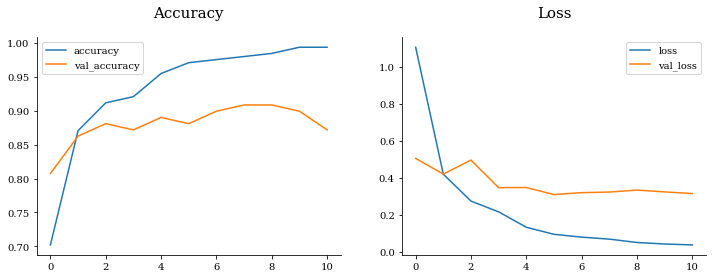

In [ ]:
vgg16_history = compile_and_fit_model(vgg16_model)

1/1 [==============================] - 0s 226ms/step


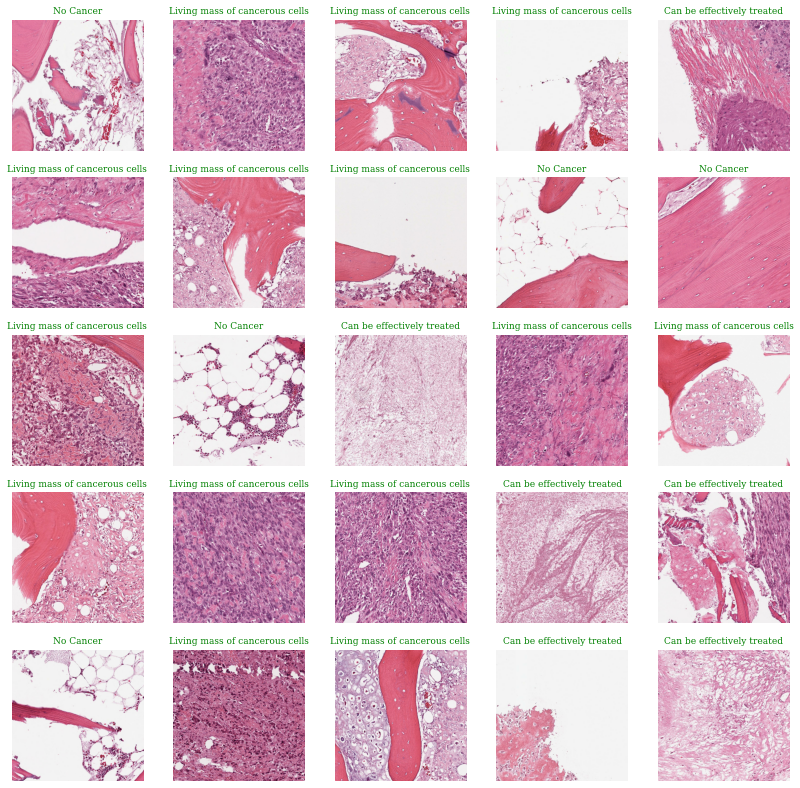

In [ ]:


plot_predictions(vgg16_model)



In [ ]:
pretrained_resnet_base = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_resnet_base.trainable = False

resnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input),
    pretrained_resnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
resnet_model.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 23,827,459
Trainable params: 262,659
Non-trainable params: 23,564,800
_________________________________________________________________


Epoch 1/25
18/18 [==============================] - 11s 288ms/step - loss: 0.5740 - accuracy: 0.7864 - val_loss: 0.3810 - val_accuracy: 0.8716 - lr: 0.0010
Epoch 2/25
18/18 [==============================] - 2s 139ms/step - loss: 0.2346 - accuracy: 0.9114 - val_loss: 0.3325 - val_accuracy: 0.8716 - lr: 0.0010
Epoch 3/25
18/18 [==============================] - 2s 106ms/step - loss: 0.1497 - accuracy: 0.9682 - val_loss: 0.4327 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 4/25
18/18 [==============================] - 2s 108ms/step - loss: 0.1417 - accuracy: 0.9477 - val_loss: 0.4911 - val_accuracy: 0.8349 - lr: 0.0010
Epoch 5/25
18/18 [==============================] - 2s 114ms/step - loss: 0.1316 - accuracy: 0.9545 - val_loss: 0.2985 - val_accuracy: 0.9083 - lr: 0.0010
Epoch 6/25
18/18 [==============================] - 2s 106ms/step - loss: 0.0840 - accuracy: 0.9818 - val_loss: 0.4195 - val_accuracy: 0.8624 - lr: 0.0010
Epoch 7/25
18/18 [==============================] - 2s 117ms/step - l

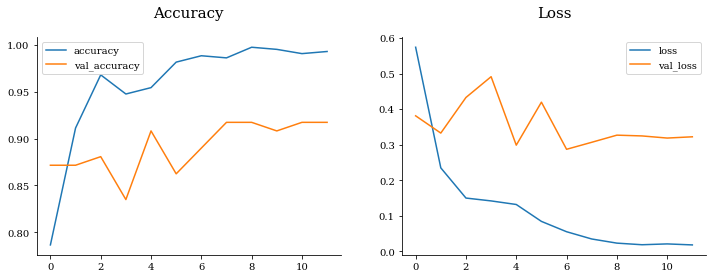

In [ ]:
resnet_history = compile_and_fit_model(resnet_model)

1/1 [==============================] - 1s 932ms/step


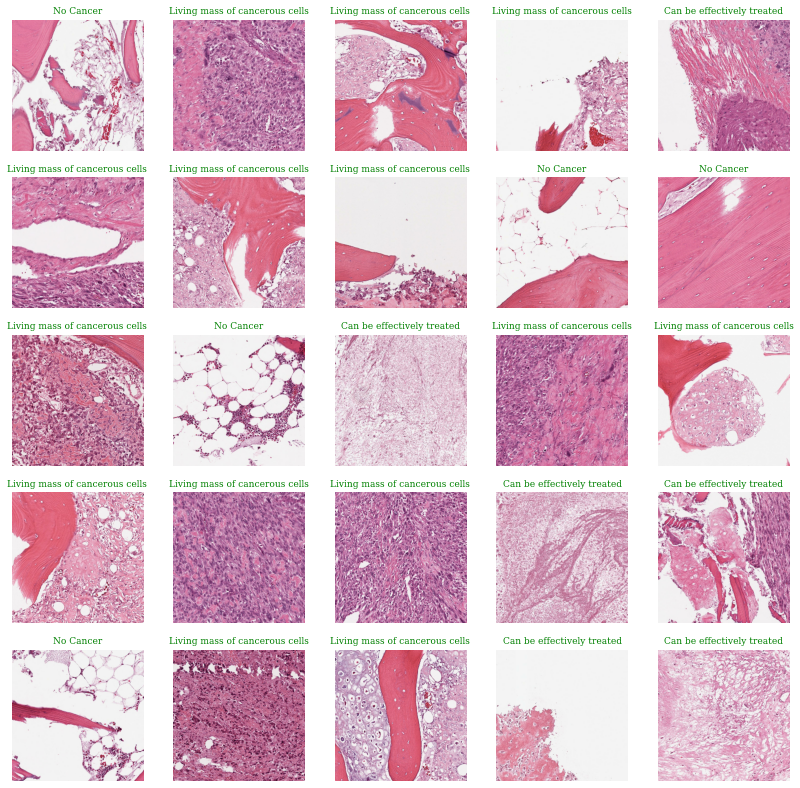

In [ ]:
plot_predictions(resnet_model)

In [ ]:


prerained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights="imagenet", pooling="avg",
)
prerained_efficientnet_base.trainable = False

efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    prerained_efficientnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
efficientnet_model.summary()



27018416/27018416 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 1280)             6575239   
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 6,739,594
Trainable params: 164,355
Non-trainable params: 6,575,239
_________________________________________________________________


Epoch 1/25
18/18 [==============================] - 19s 398ms/step - loss: 0.6360 - accuracy: 0.7227 - val_loss: 0.4028 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 2/25
18/18 [==============================] - 2s 114ms/step - loss: 0.3307 - accuracy: 0.8773 - val_loss: 0.3429 - val_accuracy: 0.8991 - lr: 0.0010
Epoch 3/25
18/18 [==============================] - 2s 113ms/step - loss: 0.2393 - accuracy: 0.9227 - val_loss: 0.3047 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 4/25
18/18 [==============================] - 2s 113ms/step - loss: 0.1937 - accuracy: 0.9318 - val_loss: 0.2637 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 5/25
18/18 [==============================] - 2s 134ms/step - loss: 0.1303 - accuracy: 0.9705 - val_loss: 0.2534 - val_accuracy: 0.8991 - lr: 0.0010
Epoch 6/25
18/18 [==============================] - 2s 112ms/step - loss: 0.1121 - accuracy: 0.9682 - val_loss: 0.2592 - val_accuracy: 0.9174 - lr: 0.0010
Epoch 7/25
18/18 [==============================] - 2s 104ms/step - l

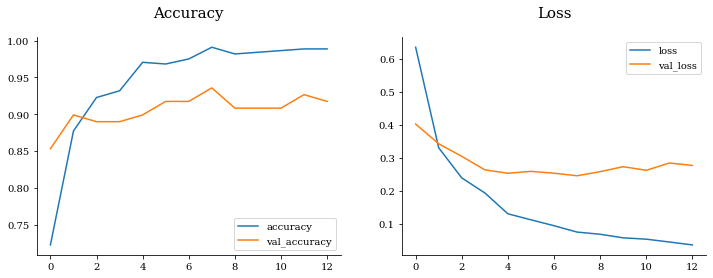

In [ ]:


efficientnet_history = compile_and_fit_model(efficientnet_model)



1/1 [==============================] - 2s 2s/step


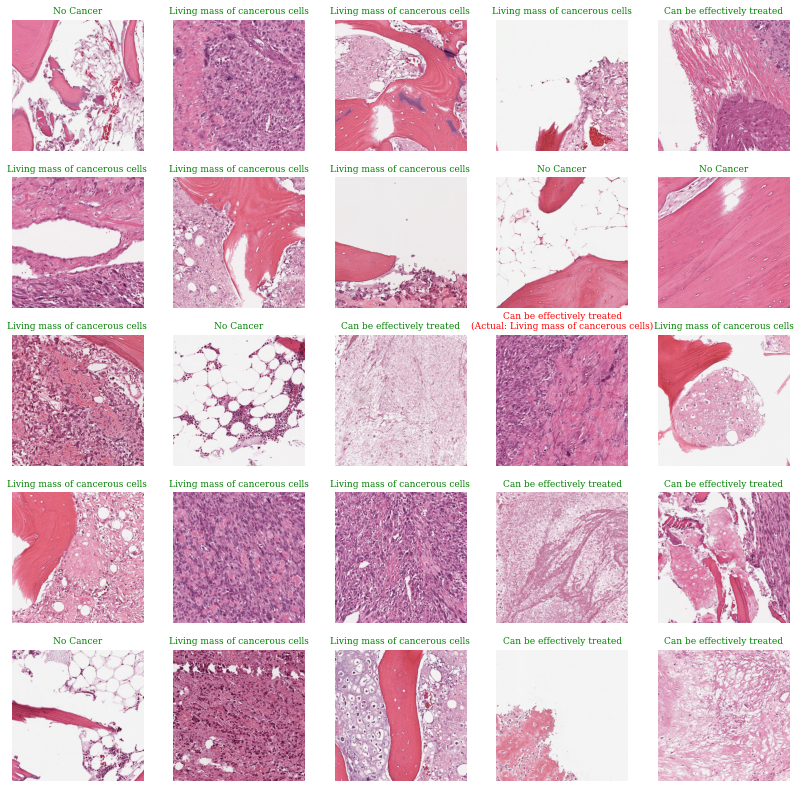

In [ ]:


plot_predictions(efficientnet_model)



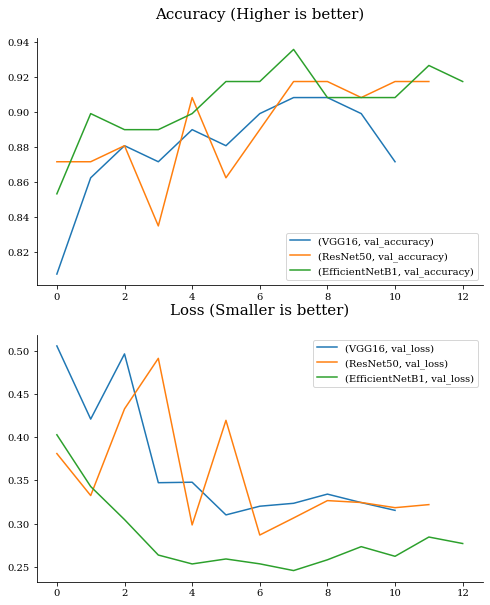

In [ ]:
vgg_df = pd.DataFrame(vgg16_history.history)
resnet_df = pd.DataFrame(resnet_history.history)
efficientnet_df = pd.DataFrame(efficientnet_history.history)
combined = pd.concat([vgg_df, resnet_df, efficientnet_df], axis=1,
                     keys=["VGG16", "ResNet50", "EfficientNetB1"])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
combined.filter(like="val_accuracy").plot(ax=ax1)
combined.filter(like="val_loss").plot(ax=ax2)
ax1.set_title("Accuracy (Higher is better)", size=15, pad=20)
ax1.legend(title="")
ax2.set_title("Loss (Smaller is better)", size=15, pad=20)
_ = ax2.legend(title="")